# Mapping 3
- Line of Interest (circle & straight line)
- Frequency spectrum mapping
- Linear interpolation

Formant ansatz

In [136]:
import matplotlib.pyplot as plt
from datetime import datetime
from IPython.display import Audio
import pyamapping

import numpy as np
from pya import *

%matplotlib widget

In [2]:
s = startup()

# Simulation

In [3]:
import simulation

n = 128
sim_speed = 0.004
sim_fps = 400
duration = 6
frame_amount = duration * sim_fps

initial_state = np.array([[simulation.gaussian(x, y, n, offset=[-0.6, 0.0], width=0.15) for x in range(n)] for y in range(n)])
potential = np.array([[simulation.parabola(x, y, n, offset=[0, 0], factor=10000) for x in range(n)] for y in range(n)])

multi_slit = [(-15, -13), (-8, -6), (-1, 1), (6, 8), (13, 15)]
double_slit = [(-4, -2), (2, 4)]
single_slit = [(-2, 2)]
slits = double_slit

frames = simulation.sim(n, sim_fps, duration, slits, sim_speed, initial_state=initial_state, potential=potential)

In [261]:
scanning_audio = np.abs(frames[::sim_fps//3].flatten())**2

Audio(scanning_audio, rate=49152)

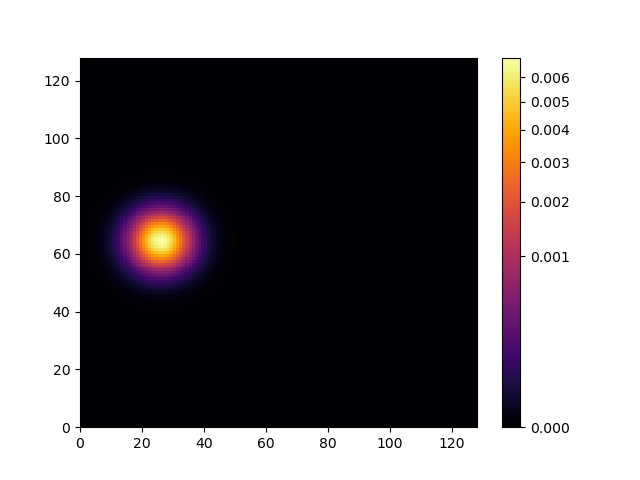

In [4]:
import matplotlib
plt.figure()
plt.pcolormesh(np.abs(frames[0]) ** 2, cmap='inferno', norm=matplotlib.colors.PowerNorm(vmin=0, vmax=np.max(np.square(np.abs(frames))), gamma=0.4))
# plt.pcolormesh(potential, vmin=0, vmax=20000)
plt.colorbar()
plt.show()

# Sonification

In [139]:
# circle of interest
def circle(radius, center, num_points):
    radians = np.linspace(0, 2 * np.pi, num_points, endpoint=False)
    x = (0.5 * n * (radius * np.sin(radians) + 1 + center[0]))
    y = (0.5 * n * (radius * np.cos(radians) + 1 + center[1]))
    return x, y

# half circle (bottom to top)
def half_circle(radius, center, num_points):
    radians = np.linspace(0, np.pi, num_points, endpoint=True)
    x = (0.5 * n * (radius * np.sin(radians) + 1 + center[0]))
    y = (0.5 * n * (radius * np.cos(radians) + 1 + center[1]))
    return x, y

# line of interest
def line(start, end, num_points):
    t = np.linspace(0, 1, num_points, endpoint=False)
    x = start[0] + t * (end[0] - start[0])
    y = start[1] + t * (end[1] - start[1])
    return x, y

def log_line(start, end, num_points):
    t = np.log2(np.arange(0, num_points) + 1) / np.log2(num_points)
    x = start[0] + t * (end[0] - start[0])
    y = start[1] + t * (end[1] - start[1])
    return x, y

In [42]:
log_line([0, 0], [1, 0], 10)

(array([64.        , 64.30103   , 64.47712125, 64.60205999, 64.69897   ,
        64.77815125, 64.84509804, 64.90308999, 64.95424251, 65.        ]),
 array([64., 64., 64., 64., 64., 64., 64., 64., 64., 64.]))

In [43]:
import os
os.environ['NUMEXPR_MAX_THREADS'] = '20'
os.environ['NUMEXPR_NUM_THREADS'] = '16'
import numexpr as ne

def interpolate_parallel(frames, indices, x_vals, y_vals):
    # Hardcoded interpolation
    # Way faster than any other interpolation!
    t = np.array([indices, y_vals, x_vals]) % 1
    t0, t1, t2 = t[0], t[1], t[2]
    floors = np.floor([indices, y_vals, x_vals]).astype(int)
    ceils  = np.ceil ([indices, y_vals, x_vals]).astype(int)
    
    f0 = frames[floors[0], floors[1], floors[2]]
    f1 = frames[floors[0], floors[1], ceils [2]]
    f2 = frames[floors[0], ceils [1], floors[2]]
    f3 = frames[floors[0], ceils [1], ceils [2]]
    f4 = frames[ceils [0], floors[1], floors[2]]
    f5 = frames[ceils [0], floors[1], ceils [2]]
    f6 = frames[ceils [0], ceils [1], floors[2]]
    f7 = frames[ceils [0], ceils [1], ceils [2]]
    
    return ne.evaluate('''\\
            ((1-t0) * ((1-t1) * ((1-t2) * real(abs(f0)) ** 2 \\
                              +     t2  * real(abs(f1)) ** 2) \\
                    +     t1  * ((1-t2) * real(abs(f2)) ** 2 \\
                              +     t2  * real(abs(f3)) ** 2)) \\
              + t0  * ((1-t1) * ((1-t2) * real(abs(f4)) ** 2 \\
                              +     t2  * real(abs(f5)) ** 2) \\
                    +     t1  * ((1-t2) * real(abs(f6)) ** 2 \\
                              +     t2  * real(abs(f7)) ** 2))) \\
            ''', local_dict=locals())


def interpolate(frames, indices, x_vals, y_vals):
    t = np.array([indices, y_vals, x_vals]) % 1
    floors = np.floor([indices, y_vals, x_vals]).astype(int)
    ceils  = np.ceil ([indices, y_vals, x_vals]).astype(int)
    
    return ((1-t[0]) * ((1-t[1]) * ((1-t[2]) * frames[floors[0], floors[1], floors[2]]
                                 +     t[2]  * frames[floors[0], floors[1], ceils [2]])
                     +     t[1]  * ((1-t[2]) * frames[floors[0], ceils [1], floors[2]]
                                 +     t[2]  * frames[floors[0], ceils [1], ceils [2]]))
             + t[0]  * ((1-t[1]) * ((1-t[2]) * frames[ceils [0], floors[1], floors[2]]
                                 +     t[2]  * frames[ceils [0], floors[1], ceils [2]])
                     +     t[1]  * ((1-t[2]) * frames[ceils [0], ceils [1], floors[2]]
                                 +     t[2]  * frames[ceils [0], ceils [1], ceils [2]])))

In [246]:
# parameters
sample_rate = 44100
sample_amount = sample_rate * duration

f_min = 110 * 2**(3/12) 
num_frequencies = 24
# linear distribution
frequencies = f_min * np.arange(1, num_frequencies + 1)

# loudness compensation
slope = -9 # dB / Oct
loudness_compensation = 200 / (frequencies ** np.log2(10 ** (-slope / 20)))

# choose method
# x, y = circle(radius=0.6, center=[0, 0], num_points=num_frequencies)
# x, y = half_circle(radius=0.6, center=[0, 0], num_points=num_frequencies)
# x, y = line(start=[-60, 0], end=[60, 0], num_points=num_frequencies)
x, y = log_line(start=[0, 64], end=[127, 64], num_points=num_frequencies)

In [247]:
loudness_compensation[0]

0.13706233448667643

In [248]:
# Sonification
frames_indices = np.linspace(0, frame_amount - 1, sample_amount, endpoint=False)

t = np.arange(sample_amount) / sample_rate

f1 = frames_indices[:, np.newaxis].repeat(num_frequencies, axis=1).flatten()
x1 = x[np.newaxis, :].repeat(sample_amount, axis=0).flatten()
y1 = y[np.newaxis, :].repeat(sample_amount, axis=0).flatten()


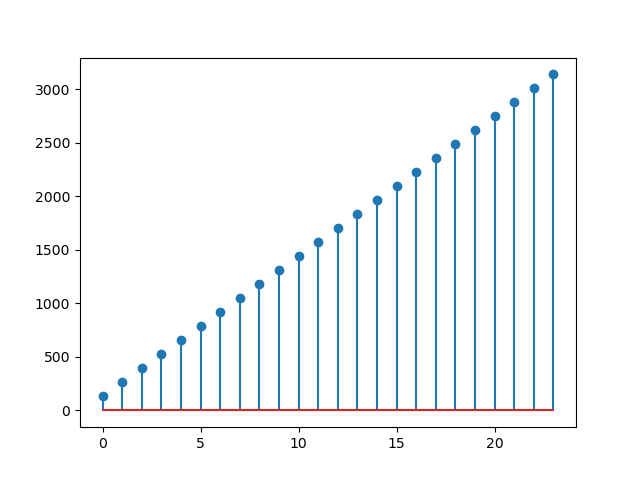

In [249]:
plt.figure()
plt.stem(frequencies)
plt.show()

In [250]:
# action
data = interpolate(frames, f1, x1, y1).reshape(sample_amount, num_frequencies)

sini = np.sin(2 * np.pi * (frequencies[np.newaxis, :] * t[:, np.newaxis]) + np.angle(data))
sini *= loudness_compensation

audio = np.sum(sini * np.abs(data)**2, axis=1)

In [241]:
p_audio = Asig(audio, sr=sample_rate)
p_audio = p_audio.fade_in(0.005).fade_out(0.005).norm().stereo()

audio_filename = f'output/sonification_{datetime.now().strftime("%Y_%m_%d-%H_%M_%S")}.wav'
p_audio.save_wavfile(audio_filename)
print(f"Sonification saved as {audio_filename}")

Audio(p_audio.mono().sig, rate=sample_rate)

Sonification saved as output/sonification_2024_04_24-18_12_36.wav


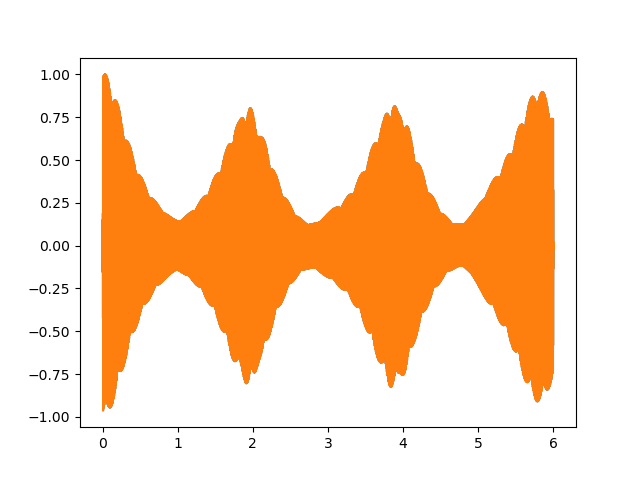

In [251]:
plt.figure()
p_audio.plot()
plt.show()

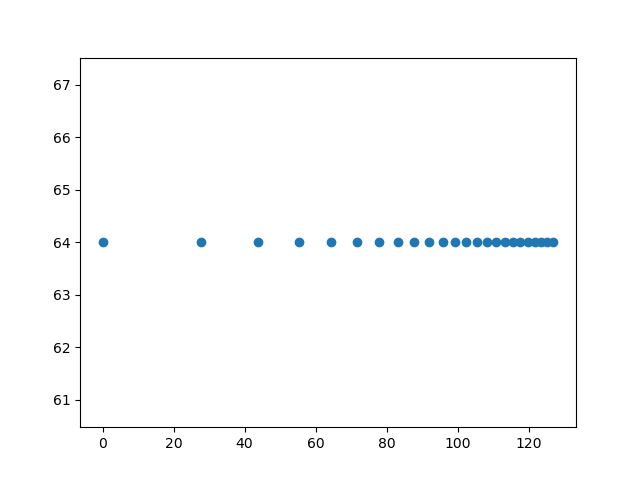

In [252]:
plt.figure()
plt.scatter(x, y)
plt.show()

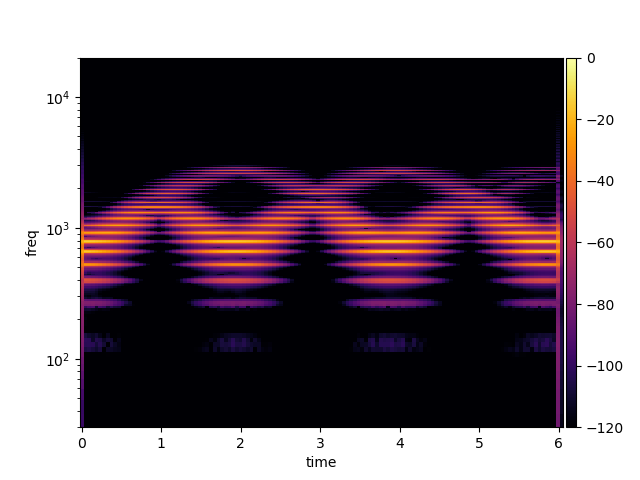

In [243]:
fix, ax = plt.subplots()
p_audio.mono().to_stft(nperseg=4096).plot(ylim=(30, 20000), fn=pyamapping.ampdb, vmax=0, vmin=-120)
ax.set_yscale('log')

# Video

video saved as output/sim_2024_04_24-17_15_11.mp4


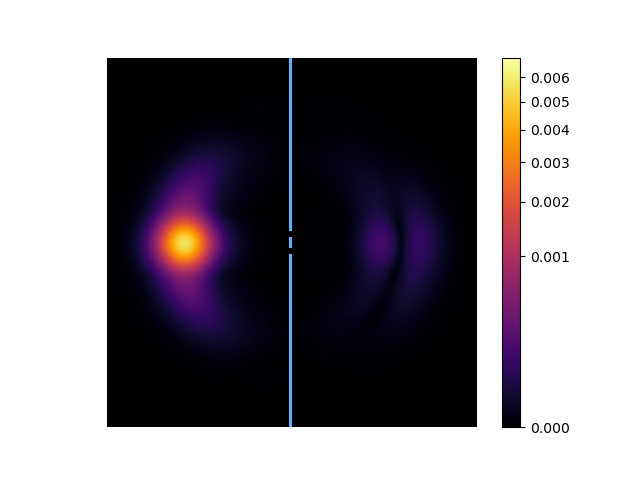

In [63]:
import video

# save video
video_filename, anim = video.create(frames, 20, frame_amount, sim_fps, slits, n)

#plt.close()

In [209]:
# combine audio & video
video.combine(audio_filename, video_filename)

Input #0, mov,mp4,m4a,3gp,3g2,mj2, from 'output/sim_2024_04_24-17_15_11.mp4':
  Metadata:
    major_brand     : isom
    minor_version   : 512
    compatible_brands: isomiso2avc1mp41
    encoder         : Lavf61.1.100
  Duration: 00:00:06.00, start: 0.000000, bitrate: 2578 kb/s
  Stream #0:0[0x1](und): Video: h264 (High) (avc1 / 0x31637661), yuv420p(progressive), 960x720, 2575 kb/s, 20 fps, 20 tbr, 10240 tbn (default)
      Metadata:
        handler_name    : VideoHandler
        vendor_id       : [0][0][0][0]
        encoder         : Lavc61.3.100 libx264
[aist#1:0/pcm_f32le @ 0x7fcfd5805a00] Guessed Channel Layout: stereo
Input #1, wav, from 'output/sonification_2024_04_24-18_00_07.wav':
  Duration: 00:00:06.00, bitrate: 2822 kb/s
  Stream #1:0: Audio: pcm_f32le ([3][0][0][0] / 0x0003), 44100 Hz, stereo, flt, 2822 kb/s
Stream mapping:
  Stream #0:0 -> #0:0 (copy)
  Stream #1:0 -> #0:1 (pcm_f32le (native) -> aac (native))
Press [q] to stop, [?] for help
Output #0, mp4, to 'output/comb

combination saved as output/combination_2024_04_24-18_06_05.mp4


[out#0/mp4 @ 0x7fcfd5804d00] video:1886KiB audio:93KiB subtitle:0KiB other streams:0KiB global headers:0KiB muxing overhead: 0.261303%
size=    1985KiB time=00:00:05.90 bitrate=2755.9kbits/s speed=28.6x    
[aac @ 0x7fcfd4f06800] Qavg: 16761.213
